## Work on real Merian image
Several updates:


#### Notes on data
Directory: `/tigress/MERIAN/merian/cosmos_stack`

Suffix: image (`osj`), data quality (`osd`), and weights (`osw`)

Cutout is made in `Merian-raw-data-process.ipynb`

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [45]:
obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap_lowz.fits')[:100]
obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                              '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
                             ) for file in obj_cat['dir']]

### Step-by-step

165, 193, 201, 259, 286, 296, 312, 396,
        449, 484]),)

In [6]:
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/')
from kuaizi.tractor.fit import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import getTargetProperty

array([109, 162, 163, 252, 487, 488])

In [21]:
channels = list('grizy') + ['N708', 'N540']

obj = obj_cat[161] # 64 for slack example
obj_id = obj['ID']


cutout = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}.fits')) for filt in 'grizy']
cutout += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_deepCoadd.fits")) for filt in channels[-2:]]

psf_list = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}_psf.fits')) for filt in 'grizy']
psf_list += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_psf.fits")) for filt in channels[-2:]]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [22]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images,#[:, 15:-15, 15:-15].byteswap().newbyteorder(), 
                #[:, 15:-15, 15:-15].byteswap().newbyteorder()
                weights=weights,#[:, 15:-15, 15:-15].byteswap().newbyteorder(),
                wcs=w, psfs=psf_pad, channels=channels) #  
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

Text(0.5, 1.0, 'Merian N708')

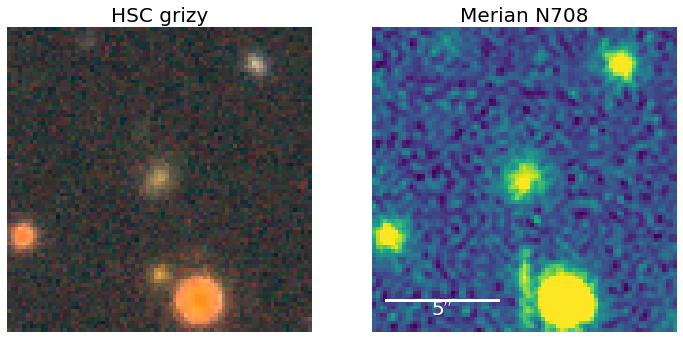

In [23]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(4)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[:4, ...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

### `cosmos_43158331061206688` i-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in i-band: 2
# Progress: 1 / 5
# Progress: 2 / 5
# Progress: 3 / 5
# Progress: 4 / 5
# Progress: 5 / 5
# Global optimization: Chi2 improvement =  0.28991044


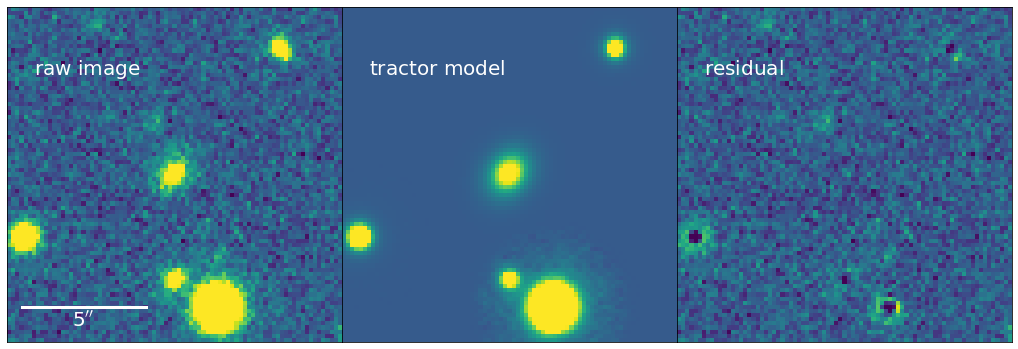

   The chi-square is 1.2294387
ExpGalaxy at pixel (39.83, 40.33) with Flux: 28.6359 and Galaxy Shape: re=0.57, ab=0.73, phi=141.9


In [24]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

### `cosmos_43158331061206688` g-band
# Total number of objects: 5
# Central object index in g-band: 2
# Global optimization: Chi2 improvement =  260.57895


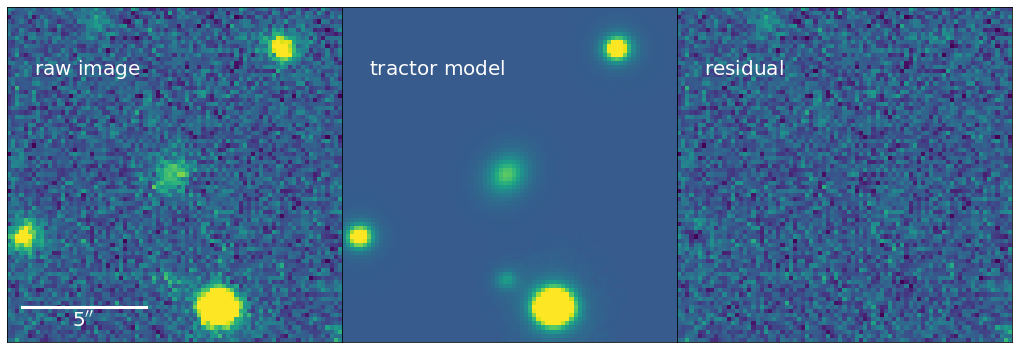

   The chi-square is 1.0471851
ExpGalaxy at pixel (39.32, 40.02) with Flux: 11.271 and Galaxy Shape: re=0.57, ab=0.73, phi=141.9


In [25]:
# Fix-all mode
model_dict['g'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'g', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

### `cosmos_43158331061206688` N708-band
# Total number of objects: 5
# Central object index in N708-band: 2
# Global optimization: Chi2 improvement =  32.518307


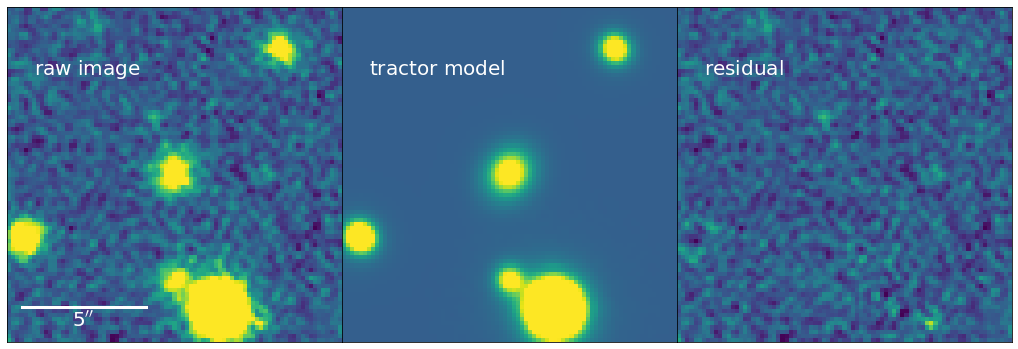

   The chi-square is 1.1323997
ExpGalaxy at pixel (40.01, 40.40) with Flux: 25.1853 and Galaxy Shape: re=0.57, ab=0.73, phi=141.9


In [26]:
# Fix-all mode
model_dict['N708'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N708', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

In [28]:
-2.5 * np.log10(getTargetProperty(model_dict['g'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

1.0123688938055326

In [29]:
obj['g_gaap_mag'] - obj['i_gaap_mag']

0.9863032256949857

In [30]:
2.5 * np.log10(getTargetProperty(model_dict['N708'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.13940739033310567

In [31]:
(obj['i_gaap_mag'] - obj['N708_gaap_mag'])

-0.06995890080349554

# Batch fitting (forced-photometry, blob-by-blob)

In [169]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row, getTargetProperty

In [41]:
meas_cat = initialize_meas_cat(obj_cat)

### Tractor modeling for obj 0
### `cosmos_43158180737346700` i-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in i-band: 1
# Progress: 1 / 6
# Progress: 2 / 6
# Progress: 3 / 6
# Progress: 4 / 6
# Progress: 5 / 6
# Progress: 6 / 6
# Global optimization: Chi2 improvement =  4.6471486


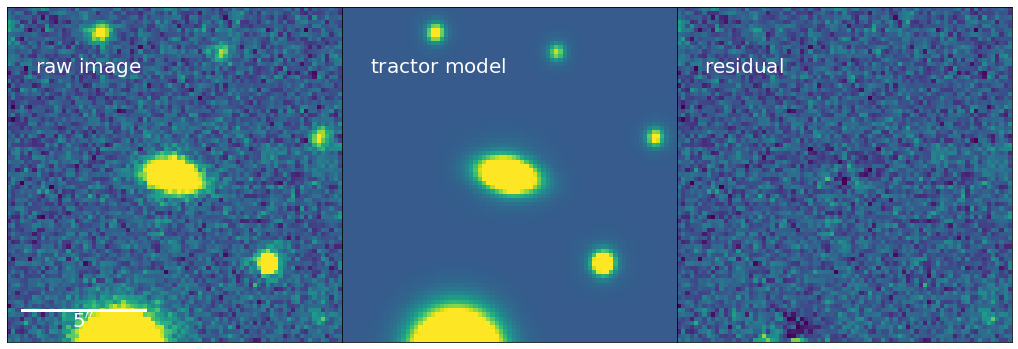

   The chi-square is 1.0907307
ExpGalaxy at pixel (38.68, 38.85) with Flux: 95.2383 and Galaxy Shape: re=0.60, ab=0.37, phi=77.9
### `cosmos_43158180737346700` g-band
    Detected 3 objects
# Total number of objects: 3
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  24.612549


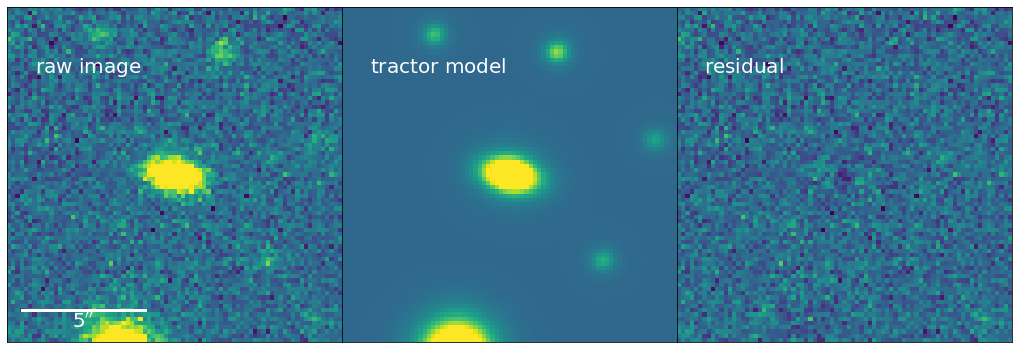

   The chi-square is 1.0136602
ExpGalaxy at pixel (26.49, -3.59) with Flux: 103.439 and Galaxy Shape: re=0.73, ab=1.01, phi=140.4
### `cosmos_43158180737346700` r-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in r-band: 1
# Global optimization: Chi2 improvement =  2.8307881


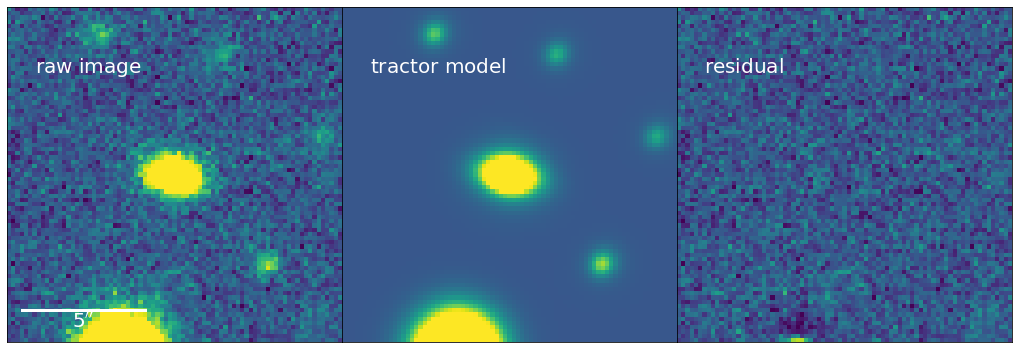

   The chi-square is 1.0284796
ExpGalaxy at pixel (38.78, 38.83) with Flux: 78.0686 and Galaxy Shape: re=0.60, ab=0.37, phi=77.9
### `cosmos_43158180737346700` z-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in z-band: 1
# Global optimization: Chi2 improvement =  0.8434917


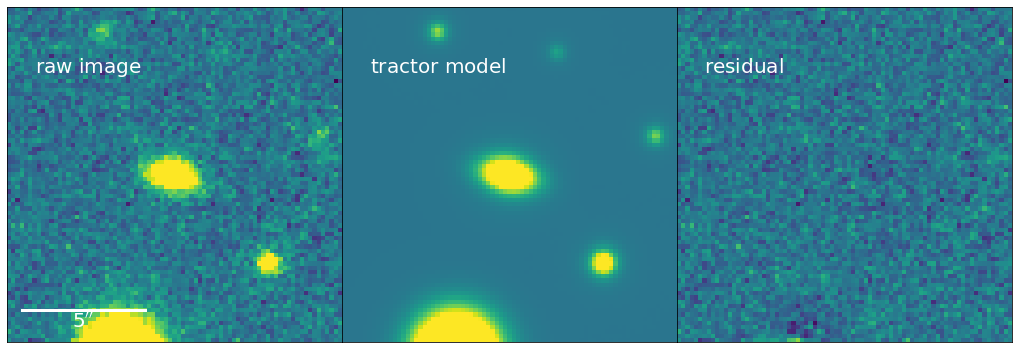

   The chi-square is 1.0320573
ExpGalaxy at pixel (38.78, 38.89) with Flux: 119.225 and Galaxy Shape: re=0.60, ab=0.37, phi=77.9
### `cosmos_43158180737346700` y-band
    Detected 3 objects
# Total number of objects: 3
# Central object index in y-band: 1
# Global optimization: Chi2 improvement =  0.37390774


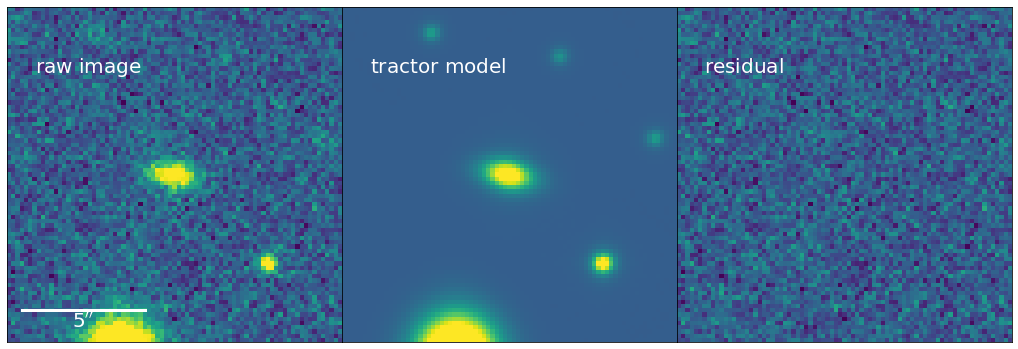

   The chi-square is 0.9840562
ExpGalaxy at pixel (38.66, 38.92) with Flux: 121.163 and Galaxy Shape: re=0.60, ab=0.37, phi=77.9
### `cosmos_43158180737346700` N708-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in N708-band: 1
# Global optimization: Chi2 improvement =  0.8491262


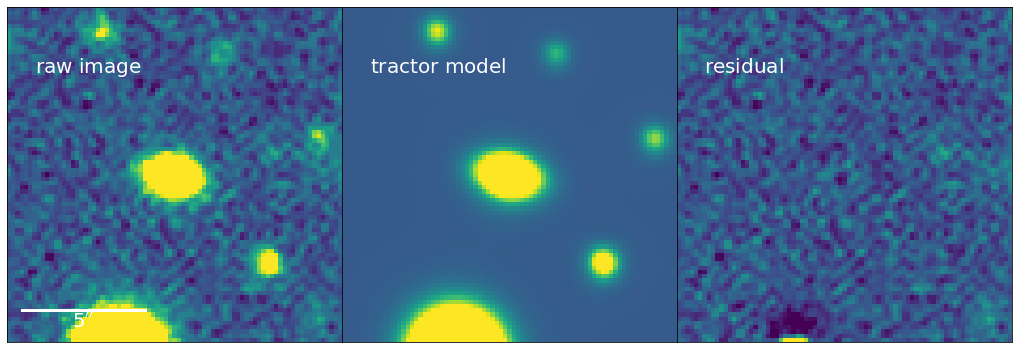

   The chi-square is 1.2928611
ExpGalaxy at pixel (38.75, 38.82) with Flux: 85.4409 and Galaxy Shape: re=0.60, ab=0.37, phi=77.9
### `cosmos_43158180737346700` N540-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  39.749626


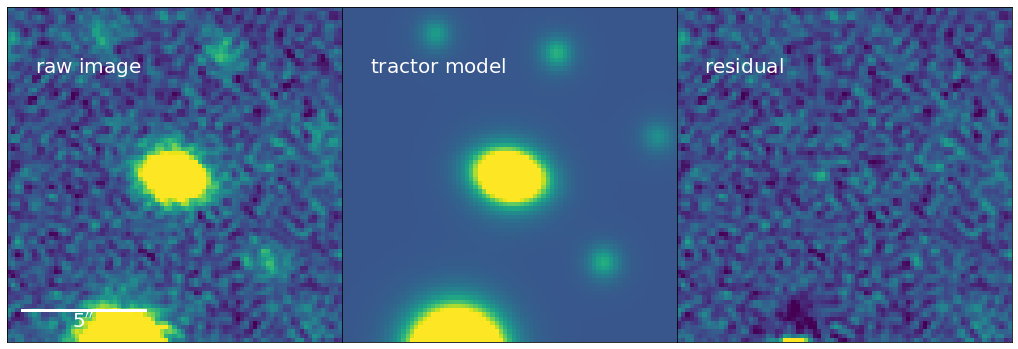

   The chi-square is 1.177872
ExpGalaxy at pixel (26.49, -3.59) with Flux: 226.644 and Galaxy Shape: re=0.73, ab=1.01, phi=140.4


In [985]:
channels = list('grizy') + ['N708', 'N540']

ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[21:21+1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['ID']

    cutout = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}.fits')) for filt in 'grizy']
    cutout += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_deepCoadd.fits")) for filt in channels[-2:]]
    psf_list = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}_psf.fits')) for filt in 'grizy']
    psf_list += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_psf.fits")) for filt in channels[-2:]]

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                     'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=True, show_fig=True)
    
    for filt in forced_channels:
        pos = True
        fix_all = True
        ref_catalog = model_dict[ref_filt].catalog.copy()
        model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data,
            fix_all=fix_all, tractor_cat=ref_catalog,
            # obj_cat=_obj_cat_i,
            # ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': pos, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                         'sersicindex': True},  # don't fix shape/sersic
            verbose=True, show_fig=True)
#     with open(os.path.join(obj['dir'], f'cosmos_{obj["ID"]}_tractor.pkl'), 'wb') as f:
#         pickle.dump(model_dict, f)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

In [247]:
getTargetProperty(model_dict['i'])

{'x': 66.95486721198893,
 'y': 67.04243210514014,
 'flux': 1.3329979571008659,
 're': 0.14354577593729978,
 'ab': 0.8324395357859868,
 'phi': 158.22717419785215,
 'x_ivar': 333.3559265136719,
 'y_ivar': 288.00396728515625,
 'flux_ivar': 6696.937762297143,
 're_ivar': 142877.1246047247,
 'ab_ivar': 2074.264404296875,
 'phi_ivar': 0.05671444907784462,
 'sersic': 1.0,
 'sersic_ivar': 0.0,
 'type': 'EXP'}

In [53]:
_write_to_row(meas_cat[81], model_dict)

ID,x,x_ivar,y,y_ivar,flux [6],flux_ivar [6],ab,ab_ivar,phi,phi_ivar,sersic,sersic_ivar,mag [6]
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
43158180737349578,20.131992420505696,2387.3701171875,20.204637008729026,2196.293212890625,0.4168569777204942 .. 1.4231366321744383,43742.76646983297 .. 43906.644890755924,0.8081650098332142,847.37744140625,145.80894182766892,0.02245868742465973,3.1811119987590892,39.56598663330078,23.22787314848449 .. 22.011487409727764


---

In [170]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [87]:
# meas_cat.write(f'./Catalogs/tractor_{suffix}_output_0_500.fits', overwrite=True)

In [84]:
suffix = 'lowz'

In [83]:
# meas_cat = vstack([Table.read('./Catalogs/tractor_lowz_output_0_250.fits'),
#                    Table.read('./Catalogs/tractor_lowz_output_250_500.fits')])
meas_cat = Table.read(f'./Catalogs/tractor_{suffix}_output_0_500.fits')
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'].data)
obj_cat = Table.read(f'./Catalogs/COSMOS_cutouts_tractor_gaap_{suffix}.fits')[:500]
obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                              '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
                             ) for file in obj_cat['dir']]

In [74]:
print('Number of failures = ', np.sum(meas_cat['flux'][0] == 0.0))

Number of failures =  0


In [75]:
obj_cat['mag'] = np.hstack([obj_cat[f'{filt}_gaap_mag'].data[:, None] for filt in list('grizy') + ['N708']])

In [76]:
obj_cat['mag_tractor'] = 22.5 - 2.5 * np.log10(np.hstack(
    [obj_cat[f'{filt}_tractor_flux'].data[:, None] for filt in list('grizy') + ['N708']]))

In [77]:
channels = list('grizy') + ['N708', 'N540']

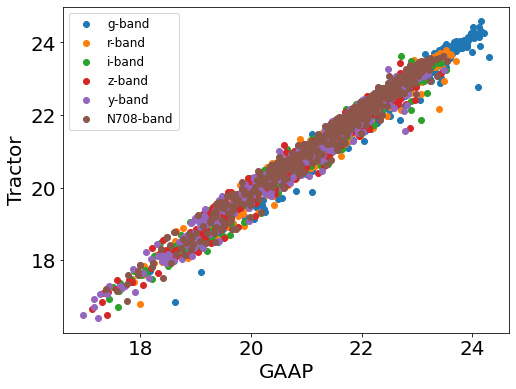

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    filt = channels[i]
    plt.scatter(obj_cat['mag'][:, i], meas_cat['mag'][:, i], label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

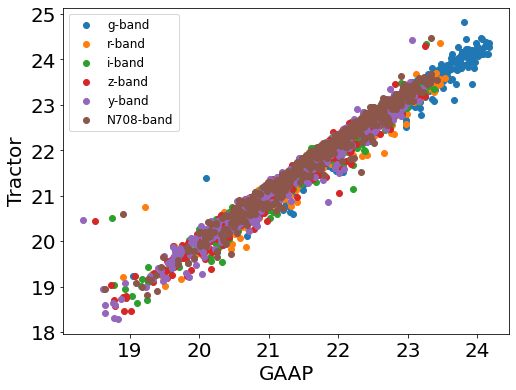

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    filt = channels[i]
    plt.scatter(obj_cat['mag'][:, i], meas_cat['mag'][:, i], label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

Text(0, 0.5, 'GAAP - Tractor')

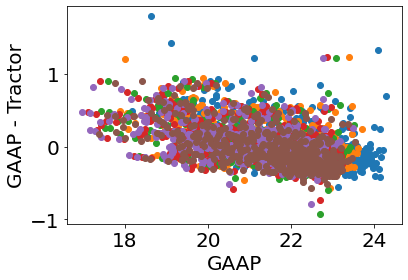

In [79]:
for i in range(6):
    plt.scatter(obj_cat['mag'][:, i], obj_cat['mag'][:, i] - meas_cat['mag'][:, i])

plt.xlabel('GAAP')
plt.ylabel('GAAP - Tractor')

01234 5
grizy N708

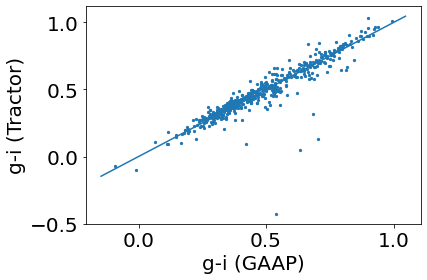

In [80]:
plt.scatter(obj_cat['mag'][:, 0] - obj_cat['mag'][:, 1], 
            meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1],
            s=5)

plt.xlabel('g-i (GAAP)')
plt.ylabel('g-i (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

In [1013]:
diff = ((obj_cat['mag'][:, 0] - obj_cat['mag'][:, 2]) - (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]))

In [1015]:
np.std(diff)

0.0608527435185473

In [1011]:
np.where(np.abs(diff) > 0.15)

(array([ 61, 102, 111, 115, 134, 163, 216, 235, 379, 429, 439, 487]),)

(-0.5, 1.0)

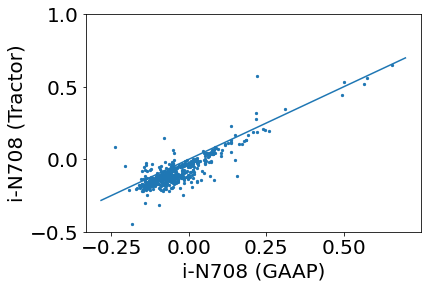

In [82]:
plt.scatter(obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5], 
            meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5], 
            s=5)

plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

plt.ylim(-0.5, 1.)

In [952]:
iN708_gaap = obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5]
iN708_tractor = meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5]

In [953]:
np.where(np.abs(iN708_gaap - iN708_tractor) > .3)

(array([], dtype=int64),)

In [954]:
meas_cat['mag'][81]

array([20.8401313 , 19.99707926, 19.64847698, 19.34923956, 19.27102258,
       19.78607174, 20.31163345])

In [957]:
obj_cat['mag'][81]

array([21.00224562, 20.16014461, 19.80144533, 19.51913669, 19.4535872 ,
       19.92264317])

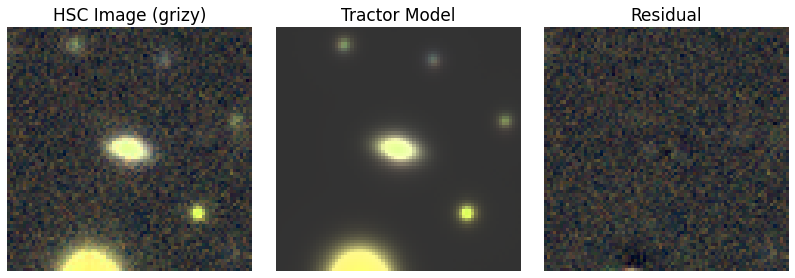

In [986]:
# ### Make figures into a PDF file (slow)
# from fpdf import FPDF
# pdf = FPDF()
# pdf.add_page()
# for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
#     pdf.image(image, 21, 11 + k * 55, 167, 55)
# pdf.output(obj_name + "_sep_tractor.pdf", "F")

# Visualize our model
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

res_rgb = scarlet.display.img_to_rgb(
    data.images - model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC Image (grizy)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
# plt.savefig(obj_name + '_sep_tractor_rgb.png', 
#             bbox_inches='tight', 
#             metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})


#clear_output()
#plt.close()